### Case: Calculate CLV

#### Step one: prepare the data and churn rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('online_clean.csv', sep='|')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685559 entries, 0 to 685558
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Invoice       685559 non-null  int64  
 1   StockCode     685559 non-null  object 
 2   Description   685559 non-null  object 
 3   Quantity      685559 non-null  int64  
 4   Invoice_time  685559 non-null  object 
 5   Price         685559 non-null  float64
 6   CustomerID    685559 non-null  float64
 7   Country       685559 non-null  object 
 8   Purchase_dt   685559 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 47.1+ MB


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt
0,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04
1,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04
2,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04
3,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04
4,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28,6.95,14590.0,United Kingdom,2010-01-04


- pandas.to_datetime() convert object to date

In [5]:
df['Purchase_dt']=pd.to_datetime(df['Purchase_dt'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685559 entries, 0 to 685558
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       685559 non-null  int64         
 1   StockCode     685559 non-null  object        
 2   Description   685559 non-null  object        
 3   Quantity      685559 non-null  int64         
 4   Invoice_time  685559 non-null  object        
 5   Price         685559 non-null  float64       
 6   CustomerID    685559 non-null  float64       
 7   Country       685559 non-null  object        
 8   Purchase_dt   685559 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 47.1+ MB


check date range

In [7]:
(df['Purchase_dt'].min(),df['Purchase_dt'].max())

(Timestamp('2010-01-04 00:00:00'), Timestamp('2011-12-23 00:00:00'))

select one year data as observation window:

In [8]:
df_obs = df.loc[(df['Purchase_dt'] >= '2010-02-01') & (df['Purchase_dt'] <= '2011-01-31')]

In [9]:
df_obs['Purchase_dt'].unique()

array(['2010-02-01T00:00:00.000000000', '2010-02-02T00:00:00.000000000',
       '2010-02-03T00:00:00.000000000', '2010-02-04T00:00:00.000000000',
       '2010-02-05T00:00:00.000000000', '2010-02-07T00:00:00.000000000',
       '2010-02-08T00:00:00.000000000', '2010-02-09T00:00:00.000000000',
       '2010-02-10T00:00:00.000000000', '2010-02-11T00:00:00.000000000',
       '2010-02-12T00:00:00.000000000', '2010-02-14T00:00:00.000000000',
       '2010-02-15T00:00:00.000000000', '2010-02-16T00:00:00.000000000',
       '2010-02-17T00:00:00.000000000', '2010-02-18T00:00:00.000000000',
       '2010-02-19T00:00:00.000000000', '2010-02-21T00:00:00.000000000',
       '2010-02-22T00:00:00.000000000', '2010-02-23T00:00:00.000000000',
       '2010-02-24T00:00:00.000000000', '2010-02-25T00:00:00.000000000',
       '2010-02-26T00:00:00.000000000', '2010-02-28T00:00:00.000000000',
       '2010-03-01T00:00:00.000000000', '2010-03-02T00:00:00.000000000',
       '2010-03-03T00:00:00.000000000', '2010-03-04

practice: create the dataframe for post-observation period

In [10]:
df_after = df.loc[(df['Purchase_dt'] > '2011-01-31')]

return customers in observation window and customers post-observation window：

In [11]:
cus_list=df_obs['CustomerID'].unique()

In [12]:
cus_list.shape

(3894,)

In [13]:
cus_after_list=df_after['CustomerID'].unique()

In [14]:
cus_after_list.shape

(3857,)

- use numpy.isin(element, test_elements, assume_unique=False, invert=False)to check whether customers in obs window repurchased

In [15]:
np.isin(cus_list, cus_after_list)

array([ True, False,  True, ...,  True, False, False])

In [16]:
np.isin(cus_list, cus_after_list).shape

(3894,)

define churned customers：

In [17]:
num_remain= cus_list[np.isin(cus_list, cus_after_list)]

In [18]:
num_left = cus_list[~np.isin(cus_list, cus_after_list)]

In [19]:
cus_list.shape[0]

3894

In [20]:
churn_rate = num_left.shape[0] / cus_list.shape[0]

In [21]:
print(churn_rate)

0.3602978941961993


#### Step Two：calculate R(Recency),F(Frequency),M(monetary) score，and calculate total RFM score

- Recency: the period between last purchase and 'current'
- Frequency: the average number of purchase within a concern period
- Monetary: the average purhcase dollar amount within a concern period

- Recency:

    - define 'current'

In [22]:
df_rfm=df_obs.copy()

In [23]:
df_rfm.loc[:,'current'] = pd.to_datetime('2011-02-01')

In [24]:
df_rfm['current']

19251    2011-02-01
19252    2011-02-01
19253    2011-02-01
19254    2011-02-01
19255    2011-02-01
            ...    
364440   2011-02-01
364441   2011-02-01
364442   2011-02-01
364443   2011-02-01
364444   2011-02-01
Name: current, Length: 345194, dtype: datetime64[ns]

    - calculate the range

In [25]:
df_rfm['range']=df_rfm['current']-df_rfm['Purchase_dt']

In [26]:
df_rfm.head(10)

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,current,range
19251,496349,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19252,496349,21524,SPOTTY HOME SWEET HOME DOORMAT,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19253,496349,48116,DOOR MAT MULTICOLOUR STRIPE,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19254,496349,48129,DOOR MAT TOPIARY,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19255,496349,48138,DOOR MAT UNION FLAG,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19256,496349,48189,DOOR MAT FRIENDSHIP,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19257,496349,48194,DOORMAT HEARTS,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19258,496349,48197,DOOR MAT BIRD ON THE WIRE,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19259,496349,84971S,SMALL HEART FLOWERS HOOK,24,2010-02-01 8:13,0.85,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days
19260,496349,85178,VICTORIAN SEWING KIT,12,2010-02-01 8:13,1.25,14739.0,United Kingdom,2010-02-01,2011-02-01,365 days


    - return the minimal range

In [27]:
df_rfm.groupby('CustomerID')['range'].min()

CustomerID
12346.0    14 days
12608.0    93 days
12745.0   175 days
12746.0   229 days
12747.0    12 days
            ...   
18283.0     9 days
18284.0   120 days
18285.0   349 days
18286.0   165 days
18287.0    71 days
Name: range, Length: 3894, dtype: timedelta64[ns]

In [28]:
#check:
df_rfm.loc[df_rfm['CustomerID']==18283.0]

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,current,range
33418,498547,20971,PINK BLUE FELT CRAFT TRINKET BOX,1,2010-02-19 17:16,1.25,18283.0,United Kingdom,2010-02-19,2011-02-01,347 days
33419,498547,84836,ZINC METAL HEART DECORATION,1,2010-02-19 17:16,1.25,18283.0,United Kingdom,2010-02-19,2011-02-01,347 days
33420,498547,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2010-02-19 17:16,2.95,18283.0,United Kingdom,2010-02-19,2011-02-01,347 days
33421,498547,22069,BROWN PIRATE TREASURE CHEST,2,2010-02-19 17:16,1.65,18283.0,United Kingdom,2010-02-19,2011-02-01,347 days
33422,498547,20969,RED FLORAL FELTCRAFT SHOULDER BAG,1,2010-02-19 17:16,3.75,18283.0,United Kingdom,2010-02-19,2011-02-01,347 days
...,...,...,...,...,...,...,...,...,...,...,...
358733,541854,21870,I CAN ONLY PLEASE ONE PERSON MUG,6,2011-01-23 14:58,1.25,18283.0,United Kingdom,2011-01-23,2011-02-01,9 days
358734,541854,22649,STRAWBERRY FAIRY CAKE TEAPOT,1,2011-01-23 14:58,4.95,18283.0,United Kingdom,2011-01-23,2011-02-01,9 days
358735,541854,21068,VINTAGE BILLBOARD LOVE/HATE MUG,6,2011-01-23 14:58,1.25,18283.0,United Kingdom,2011-01-23,2011-02-01,9 days
358736,541854,21874,GIN AND TONIC MUG,3,2011-01-23 14:58,1.25,18283.0,United Kingdom,2011-01-23,2011-02-01,9 days


- Frequency:

In [29]:
df_rfm.groupby('CustomerID')['Invoice'].nunique()

CustomerID
12346.0     3
12608.0     1
12745.0     2
12746.0     1
12747.0    15
           ..
18283.0     8
18284.0     1
18285.0     1
18286.0     1
18287.0     4
Name: Invoice, Length: 3894, dtype: int64

In [30]:
df_rfm.loc[df_rfm['CustomerID']==12346.0]

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,current,range
41520,499763,20682,RED SPOTTY CHILDS UMBRELLA,1,2010-03-02 13:08,3.25,12346.0,United Kingdom,2010-03-02,2011-02-01,336 days
41521,499763,20679,EDWARDIAN PARASOL RED,1,2010-03-02 13:08,5.95,12346.0,United Kingdom,2010-03-02,2011-02-01,336 days
41522,499763,15056N,EDWARDIAN PARASOL NATURAL,1,2010-03-02 13:08,5.95,12346.0,United Kingdom,2010-03-02,2011-02-01,336 days
41523,499763,15056BL,EDWARDIAN PARASOL BLACK,1,2010-03-02 13:08,5.95,12346.0,United Kingdom,2010-03-02,2011-02-01,336 days
41524,499763,15056P,EDWARDIAN PARASOL PINK,1,2010-03-02 13:08,5.95,12346.0,United Kingdom,2010-03-02,2011-02-01,336 days
144671,513774,21524,DOORMAT SPOTTY HOME SWEET HOME,1,2010-06-28 13:53,7.49,12346.0,United Kingdom,2010-06-28,2011-02-01,218 days
144672,513774,22692,DOORMAT WELCOME TO OUR HOME,1,2010-06-28 13:53,7.49,12346.0,United Kingdom,2010-06-28,2011-02-01,218 days
144673,513774,22660,DOORMAT I LOVE LONDON,1,2010-06-28 13:53,7.49,12346.0,United Kingdom,2010-06-28,2011-02-01,218 days
144674,513774,22687,DOORMAT CHRISTMAS VILLAGE,1,2010-06-28 13:53,7.49,12346.0,United Kingdom,2010-06-28,2011-02-01,218 days
144675,513774,48173C,DOORMAT BLACK FLOCK,1,2010-06-28 13:53,7.49,12346.0,United Kingdom,2010-06-28,2011-02-01,218 days


- Monetary:

In [31]:
df_rfm['TotalPrice'] = df_rfm['Quantity'] * df_rfm['Price']

In [32]:
df_rfm.groupby('CustomerID')['TotalPrice'].sum()

CustomerID
12346.0    77352.96
12608.0      415.79
12745.0      723.85
12746.0      254.55
12747.0     4679.78
             ...   
18283.0      833.12
18284.0      461.68
18285.0      427.00
18286.0      833.48
18287.0     2345.71
Name: TotalPrice, Length: 3894, dtype: float64

In [33]:
df_obs

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt
19251,496349,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01
19252,496349,21524,SPOTTY HOME SWEET HOME DOORMAT,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01
19253,496349,48116,DOOR MAT MULTICOLOUR STRIPE,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01
19254,496349,48129,DOOR MAT TOPIARY,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01
19255,496349,48138,DOOR MAT UNION FLAG,2,2010-02-01 8:13,6.75,14739.0,United Kingdom,2010-02-01
...,...,...,...,...,...,...,...,...,...
364440,542745,22617,BAKING SET SPACEBOY DESIGN,8,2011-01-31 16:47,4.95,15881.0,United Kingdom,2011-01-31
364441,542745,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,45,2011-01-31 16:47,2.10,15881.0,United Kingdom,2011-01-31
364442,542745,22138,BAKING SET 9 PIECE RETROSPOT,13,2011-01-31 16:47,4.95,15881.0,United Kingdom,2011-01-31
364443,542746,21034,REX CASH+CARRY JUMBO SHOPPER,2,2011-01-31 16:48,0.95,15881.0,United Kingdom,2011-01-31


- calcualte the final number for R, F and M:

In [34]:
rfm = df_rfm.groupby('CustomerID').agg(recency=pd.NamedAgg(column='range', aggfunc='min'),
                                                  frequency=pd.NamedAgg(column='Invoice', aggfunc='nunique'),
                                                  monetary=pd.NamedAgg(column='TotalPrice', aggfunc='sum')
                                                 )

In [35]:
rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,14 days,3,77352.96
12608.0,93 days,1,415.79
12745.0,175 days,2,723.85
12746.0,229 days,1,254.55
12747.0,12 days,15,4679.78
...,...,...,...
18283.0,9 days,8,833.12
18284.0,120 days,1,461.68
18285.0,349 days,1,427.00


    - use DataFrame.reset_index() to use default row index

In [36]:
rfm=rfm.reset_index()

In [37]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  3894 non-null   float64        
 1   recency     3894 non-null   timedelta64[ns]
 2   frequency   3894 non-null   int64          
 3   monetary    3894 non-null   float64        
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 121.8 KB


In [38]:
rfm

,CustomerID,recency,frequency,monetary
0,12346.0,14 days,3,77352.96
1,12608.0,93 days,1,415.79
2,12745.0,175 days,2,723.85
3,12746.0,229 days,1,254.55
4,12747.0,12 days,15,4679.78
...,...,...,...,...
3889,18283.0,9 days,8,833.12
3890,18284.0,120 days,1,461.68
3891,18285.0,349 days,1,427.00
3892,18286.0,165 days,1,833.48


- convert recency to numeric format

In [39]:
rfm['recency']=rfm['recency']/np.timedelta64(1, 'D')

In [40]:
rfm['recency']

0        14.0
1        93.0
2       175.0
3       229.0
4        12.0
        ...  
3889      9.0
3890    120.0
3891    349.0
3892    165.0
3893     71.0
Name: recency, Length: 3894, dtype: float64

In [41]:
rfm.describe()

,CustomerID,recency,frequency,monetary
count,3894.000000,3894.000000,3894.000000,3894.000000
mean,15568.840010,115.373395,4.294813,1801.765360
std,1582.580633,90.163785,7.146724,6397.430151
min,12346.000000,1.000000,1.000000,1.550000
25%,14208.250000,55.000000,1.000000,299.115000
50%,15588.500000,89.000000,2.000000,645.915000
75%,16949.750000,152.000000,5.000000,1597.482500
max,18287.000000,365.000000,153.000000,269603.310000


- rank by each RFM value and generate the score:

    - use DataFrame.rank() to rank

In [42]:
rfm['r_percentile'] = rfm['recency'].rank(method='first',pct=True,ascending=True)
rfm['r_percentile']

0       0.087571
1       0.522599
2       0.785568
3       0.847714
4       0.077555
          ...   
3889    0.070621
3890    0.658706
3891    0.986133
3892    0.771957
3893    0.386492
Name: r_percentile, Length: 3894, dtype: float64

In [43]:
rfm.head(20)

,CustomerID,recency,frequency,monetary,r_percentile
0,12346.0,14.0,3,77352.96,0.087571
1,12608.0,93.0,1,415.79,0.522599
2,12745.0,175.0,2,723.85,0.785568
3,12746.0,229.0,1,254.55,0.847714
4,12747.0,12.0,15,4679.78,0.077555
5,12748.0,14.0,153,22561.52,0.087827
6,12749.0,88.0,4,2806.48,0.495378
7,12777.0,146.0,1,519.45,0.737031
8,12819.0,147.0,1,540.52,0.738829
9,12820.0,15.0,6,1434.35,0.093220


    - use pandas.qcut() to create bins

In [44]:
rfm['r_score'] = pd.qcut(rfm['r_percentile'], q=4, labels=range(4,0,-1))
rfm['r_score'].head(20)

0     4
1     2
2     1
3     1
4     4
5     4
6     3
7     2
8     2
9     4
10    1
11    3
12    1
13    4
14    4
15    2
16    2
17    3
18    1
19    3
Name: r_score, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [45]:
rfm['r_score'].value_counts()

1    974
4    974
2    973
3    973
Name: r_score, dtype: int64

practice: perform the similar calculate for Frequency and Monetary

In [46]:
rfm['m_percentile'] = rfm['monetary'].rank(method='first', pct=True,ascending=False)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))
rfm.head(20)

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4
5,12748.0,14.0,153,22561.52,0.087827,4,0.007704,4
6,12749.0,88.0,4,2806.48,0.495378,3,0.131998,4
7,12777.0,146.0,1,519.45,0.737031,2,0.572162,2
8,12819.0,147.0,1,540.52,0.738829,2,0.561120,2
9,12820.0,15.0,6,1434.35,0.093220,4,0.277607,3


In [47]:
rfm['f_percentile'] = rfm['frequency'].rank(method='first',pct=True,ascending=False)
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 4, labels=range(4,0,-1))
rfm.head(50)

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4,0.356703,3
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2,0.660760,2
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3,0.470981,3
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1,0.661017,2
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4,0.037494,4
5,12748.0,14.0,153,22561.52,0.087827,4,0.007704,4,0.000257,4
6,12749.0,88.0,4,2806.48,0.495378,3,0.131998,4,0.268875,3
7,12777.0,146.0,1,519.45,0.737031,2,0.572162,2,0.661274,2
8,12819.0,147.0,1,540.52,0.738829,2,0.561120,2,0.661531,2
9,12820.0,15.0,6,1434.35,0.093220,4,0.277607,3,0.171546,4


In [48]:
rfm['frequency'].value_counts()

1      1322
2       739
3       445
4       342
5       215
6       164
7       144
8        97
9        79
10       52
11       48
12       38
13       24
14       23
16       23
15       17
17       16
18       13
21        9
20        9
23        7
19        7
24        7
31        4
30        4
45        3
22        3
32        3
29        2
39        2
27        2
40        2
26        2
74        2
36        2
28        1
34        1
38        1
153       1
46        1
25        1
87        1
63        1
51        1
43        1
41        1
37        1
33        1
122       1
48        1
114       1
99        1
86        1
64        1
58        1
54        1
52        1
110       1
Name: frequency, dtype: int64

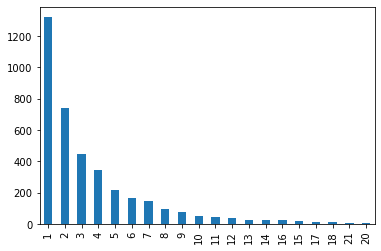

In [49]:
rfm['frequency'].value_counts()[:20].plot(kind='bar')

In [50]:
(rfm['frequency'].min(), rfm['frequency'].max())

(1, 153)

- manually create bins for Frequency:

    - DataFrame.apply(): apply functions to dateframe

In [60]:
rfm['f_score'] = rfm['frequency'].apply(
    lambda x: 1 if x <= 1 else 2 if x <= 5 \
        else 3 if x <= 10 else 4
)

In [61]:
rfm['f_score'].value_counts()

2    1741
1    1322
3     536
4     295
Name: f_score, dtype: int64

In [62]:
rfm.head()

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4,0.356703,2
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2,0.660760,1
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3,0.470981,2
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1,0.661017,1
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4,0.037494,4


- sum 3 scores and calculate the final RFM score

In [64]:
rfm['rfm_score'] = rfm['r_score'].astype(np.int8) + rfm['f_score'].astype(np.int8).astype(np.int8) + rfm['m_score'].astype(np.int8)

In [65]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CustomerID    3894 non-null   float64 
 1   recency       3894 non-null   float64 
 2   frequency     3894 non-null   int64   
 3   monetary      3894 non-null   float64 
 4   r_percentile  3894 non-null   float64 
 5   r_score       3894 non-null   category
 6   m_percentile  3894 non-null   float64 
 7   m_score       3894 non-null   category
 8   f_percentile  3894 non-null   float64 
 9   f_score       3894 non-null   int64   
 10  rfm_score     3894 non-null   int8    
dtypes: category(2), float64(6), int64(2), int8(1)
memory usage: 255.2 KB


    - DataFrame.astype(): convert the format

In [66]:
rfm['r_score'].astype(int)

0       4
1       2
2       1
3       1
4       4
       ..
3889    4
3890    2
3891    1
3892    1
3893    3
Name: r_score, Length: 3894, dtype: int32

pracice: do the conversion for r_score and m_score and calculate the rfm_score

In [67]:
rfm['r_score']=rfm['r_score'].astype(int)

In [68]:
rfm['m_score']=rfm['m_score'].astype(int)

In [69]:
rfm.head()

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score,rfm_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4,0.356703,2,10
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2,0.660760,1,5
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3,0.470981,2,6
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1,0.661017,1,3
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4,0.037494,4,12


In [70]:
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

In [71]:
rfm.head()

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score,rfm_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4,0.356703,2,10
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2,0.660760,1,5
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3,0.470981,2,6
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1,0.661017,1,3
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4,0.037494,4,12


In [72]:
rfm['rfm_score'].value_counts()

6     493
5     484
7     476
8     476
4     430
3     410
9     367
10    274
11    257
12    227
Name: rfm_score, dtype: int64

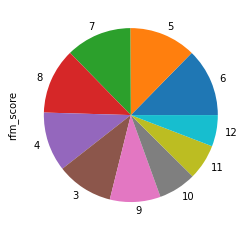

In [73]:
rfm['rfm_score'].value_counts().plot(kind='pie')

#### Step Three：Calculate the average CLV for each RFM segment

In [74]:
rfm

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score,rfm_score
0,12346.0,14.0,3,77352.96,0.087571,4,0.001541,4,0.356703,2,10
1,12608.0,93.0,1,415.79,0.522599,2,0.639445,2,0.660760,1,5
2,12745.0,175.0,2,723.85,0.785568,1,0.471238,3,0.470981,2,6
3,12746.0,229.0,1,254.55,0.847714,1,0.787879,1,0.661017,1,3
4,12747.0,12.0,15,4679.78,0.077555,4,0.063688,4,0.037494,4,12
...,...,...,...,...,...,...,...,...,...,...,...
3889,18283.0,9.0,8,833.12,0.070621,4,0.433744,3,0.134309,3,10
3890,18284.0,120.0,1,461.68,0.658706,2,0.609142,2,0.999486,1,5
3891,18285.0,349.0,1,427.00,0.986133,1,0.629687,2,0.999743,1,4
3892,18286.0,165.0,1,833.48,0.771957,1,0.433487,3,1.000000,1,5


In [75]:
clv=rfm.groupby(['rfm_score']).agg(total_customers=pd.NamedAgg(column='CustomerID', aggfunc='nunique'),
                                                  monetary=pd.NamedAgg(column='monetary', aggfunc='sum'))

In [76]:
clv

,total_customers,monetary
rfm_score,,
3,410,64775.550
4,430,116488.701
5,484,178885.140
6,493,312165.601
7,476,462854.581
8,476,621386.051
9,367,653978.820
10,274,793604.863
11,257,1182635.861


In [77]:
clv['monetary']/clv['total_customers']

rfm_score
3       157.989146
4       270.903956
5       369.597397
6       633.195945
7       972.383574
8      1305.432880
9      1781.958638
10     2896.368113
11     4601.695957
12    11582.815608
dtype: float64

In [78]:
clv['clv']=(clv['monetary']/clv['total_customers'])*1/churn_rate

In [79]:
1/churn_rate

2.7754811119030647

In [80]:
clv

,total_customers,monetary,clv
rfm_score,,,
3,410,64775.550,438.495892
4,430,116488.701,751.888813
5,484,178885.140,1025.810594
6,493,312165.601,1757.423386
7,476,462854.581,2698.832242
8,476,621386.051,3623.204302
9,367,653978.820,4945.792541
10,274,793604.863,8038.814991
11,257,1182635.861,12771.920212
